# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В наличии исторические данные: технические характеристики, комплектации и цены автомобилей. Требуется построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

Данные находятся в файле:
`autos.csv`

**Признаки**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)

## Загрузка и подготовка данных

### Загрузка библиотек, классов и метрик

In [1]:
!pip install --upgrade scikit-learn=='1.4.0' -q
!pip install phik -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 6.9 MB/s eta 0:00:00


In [2]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (20,25)

import time

import sklearn
import phik

import warnings
warnings.filterwarnings("ignore")

# загружаем функцию для работы с метриками
from sklearn.metrics import mean_squared_error, make_scorer

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor, DummyClassifier

# загружаем функцию для работы с метриками
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    confusion_matrix, recall_score, precision_score, accuracy_score,
    roc_auc_score, make_scorer
)

import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [4]:
sklearn.__version__

'1.4.0'

### Загрузка данных и знакомство с ними

In [5]:
import os

pth1 = '/datasets/autos.csv'
pth2 = '/content/autos.csv'

if os.path.exists(pth1):
    autos = pd.read_csv(pth1, sep=',')
elif os.path.exists(pth2):
    autos = pd.read_csv(pth2, sep=',')
else:
    print('PathError')

In [6]:
# Посмотрим на датасет
display(autos.head(5))
display(autos.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

### Формат названий столбцов и типов данных

**Приведем названия столбцов к snake_case**

In [7]:
autos.columns = (autos.columns
                .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                .str.lower()
             )
autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

**Приведение типов**
Приведем столбцы с датами к типу date

In [8]:
date_columns = ['date_crawled', 'date_created', 'last_seen']
for col in date_columns:
  autos[col] = pd.to_datetime(autos[col])
display(autos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

None

### Дубликаты, уникальные значения, пропуски

In [9]:
# явные дубли
autos.duplicated().sum()

4

Всего 4 явных дубликата, их можно удалить не проверяя.

In [10]:
#удаляем + контроль
autos.drop_duplicates(inplace = True)
autos.duplicated().sum()

0

**Неявные дубликаты**:
- Сначала уберем дату скачивания анкеты, и посмотрим, нет ли дублей.
- Затем уберем дату создания анкеты и тоже посмотрим

In [11]:
autos.drop(['date_crawled'], axis=1).duplicated().sum()

85

In [12]:
year_crawled = pd.DatetimeIndex(autos['date_crawled']).year
month_crawled = pd.DatetimeIndex(autos['date_crawled']).month
display(year_crawled.unique())
display(month_crawled.unique())

Index([2016], dtype='int32', name='date_crawled')

Index([3, 4], dtype='int32', name='date_crawled')

Итак, анкеты скачивали в марте и апреле 2016 года. В эти месяцы никаких резких подьемов и скачков цен не происходило (подьем цен произошел в августе на 7-10% в 2016м году), так что столбец можно удалить целиком, он не информативен.

**Однако, вначале есть смысл посмотреть остальные столбцы дат, возможно, там та же история**

In [13]:
year_created = pd.DatetimeIndex(autos['date_created']).year
month_created = pd.DatetimeIndex(autos['date_created']).month
display(year_created.unique())
display(month_created.unique())

Index([2016, 2015, 2014], dtype='int32', name='date_created')

Index([3, 4, 2, 1, 11, 12, 9, 8, 6], dtype='int32', name='date_created')

In [14]:
year_seen = pd.DatetimeIndex(autos['last_seen']).year
month_seen = pd.DatetimeIndex(autos['last_seen']).month
display(year_seen.unique())
display(month_seen.unique())

Index([2016], dtype='int32', name='last_seen')

Index([4, 3], dtype='int32', name='last_seen')

Итак, получается, что все анкеты созданы в течение трех лет: 2014-2016 гг. При этом сняты в базу анкеты были в 2016 году, и тогда же была зарегистрирована последняя активность пользователя. В этом случае все три столбца не имеют никакой связи с ценами на авто, и их можно удалить.

In [15]:
for col in date_columns:
    autos.drop([col], axis=1, inplace=True)
autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354365 non-null  int64 
 1   vehicle_type        316875 non-null  object
 2   registration_year   354365 non-null  int64 
 3   gearbox             334532 non-null  object
 4   power               354365 non-null  int64 
 5   model               334660 non-null  object
 6   kilometer           354365 non-null  int64 
 7   registration_month  354365 non-null  int64 
 8   fuel_type           321470 non-null  object
 9   brand               354365 non-null  object
 10  repaired            283211 non-null  object
 11  number_of_pictures  354365 non-null  int64 
 12  postal_code         354365 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 37.9+ MB


Удалим столбец `registration_month` - номер месяца регистрации на цену никак не влияет.

In [16]:
autos.drop(['registration_month'], axis=1, inplace=True)

Удалим столбец `postal_code` - поскольку этот код ничего не говорит о месте сделки, то он на цену никак не повлияет.

In [17]:
autos.drop(['postal_code'], axis=1, inplace=True)

In [18]:
# Посмотрим дубли
autos.duplicated().sum()

45036

In [19]:
print('Удалим {} дубликатов ({:.1%} от всех)'.format(autos.duplicated().sum(), autos.duplicated().sum()/autos.shape[0]))

Удалим 45036 дубликатов (12.7% от всех)


In [20]:
#удалим
autos.drop_duplicates(inplace = True)
autos.duplicated().sum()

0

**Посмотрим уникальные значения в столбцах: так можно определить неявные дубли, неинформативные столбцы**

In [21]:
for col in autos.columns:
    print(col, autos[col].unique())

price [  480 18300  9800 ... 12395 18429 10985]
vehicle_type [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
registration_year [1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500]
gearbox ['manual' 'auto' nan]
power [    0   190   163    75    69   102   109    

Вывод:
- Удалим столбец с количеством фото, там везде нули
- В столбце `vehicle_type` `nan` нужно заменить на `unknown`
- `fuel_type` - значения `petrol` и `gasoline` по сути означают одно и то же, можно привести к одной форме, а `nan` на `unknown`
- `model` - значения `rangerover` и `range_rover` это одна модель, приведем к форме `rangerover`, а `nan` на `unknown`

In [22]:
autos.drop(['number_of_pictures'], axis=1, inplace=True)

**Замены по неявным дублям:**

In [23]:
autos['model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [24]:
autos['fuel_type'] = autos.fuel_type.str.replace('petrol', 'gasoline')
autos['model'] = autos.model.str.replace('rangerover', 'range_rover')

**Посмотрим пропуски**

In [25]:
autos.isna().sum()

,0
price,0
vehicle_type,34559
registration_year,0
gearbox,17207
power,0
model,18361
kilometer,0
fuel_type,30764
brand,0
repaired,64558


In [26]:
# Сформируем отчет по пропускам:
for column in autos.columns:
    emptyRecords=len(autos.loc[autos[column].isnull()])
    if emptyRecords>0:
        print('- {} - содержит {} пропусков ({:.1%} от всех)'.format(column, emptyRecords, emptyRecords/autos.shape[0]))

- vehicle_type - содержит 34559 пропусков (11.2% от всех)
- gearbox - содержит 17207 пропусков (5.6% от всех)
- model - содержит 18361 пропусков (5.9% от всех)
- fuel_type - содержит 30764 пропусков (9.9% от всех)
- repaired - содержит 64558 пропусков (20.9% от всех)


Пропусков много, их нужно обработать

### Обработка пропусков

In [27]:
cols=['vehicle_type', 'fuel_type', 'model', 'gearbox', 'repaired']
for col in cols:
    autos[col] = autos[col].fillna('unknown')

In [28]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 309329 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              309329 non-null  int64 
 1   vehicle_type       309329 non-null  object
 2   registration_year  309329 non-null  int64 
 3   gearbox            309329 non-null  object
 4   power              309329 non-null  int64 
 5   model              309329 non-null  object
 6   kilometer          309329 non-null  int64 
 7   fuel_type          309329 non-null  object
 8   brand              309329 non-null  object
 9   repaired           309329 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.0+ MB


In [29]:
print('Итак, все пропуски обработаны, всего удалено {:.1%} от первоначальных данных'.format((354369-autos.shape[0])/354369))

Итак, все пропуски обработаны, всего удалено 12.7% от первоначальных данных


### Исследовательский анализ

In [30]:
autos.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,unknown,1993,manual,0,golf,150000,gasoline,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown


Посмотрим на описательные статистики

In [31]:
autos.describe()

,price,registration_year,power,kilometer
count,309329.000000,309329.000000,309329.000000,309329.000000
mean,4486.937196,2004.360105,110.976908,127217.735809
std,4564.852796,92.541399,200.969473,38532.941010
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Похоже, что во всех столбцах  сданными есть проблемы: выбросы, вызванные ошибками ввода видны (например, нулевая цена или 20 тыс лошадей мощность). Это будет лучше видно на диаграммах "ящик с усами".

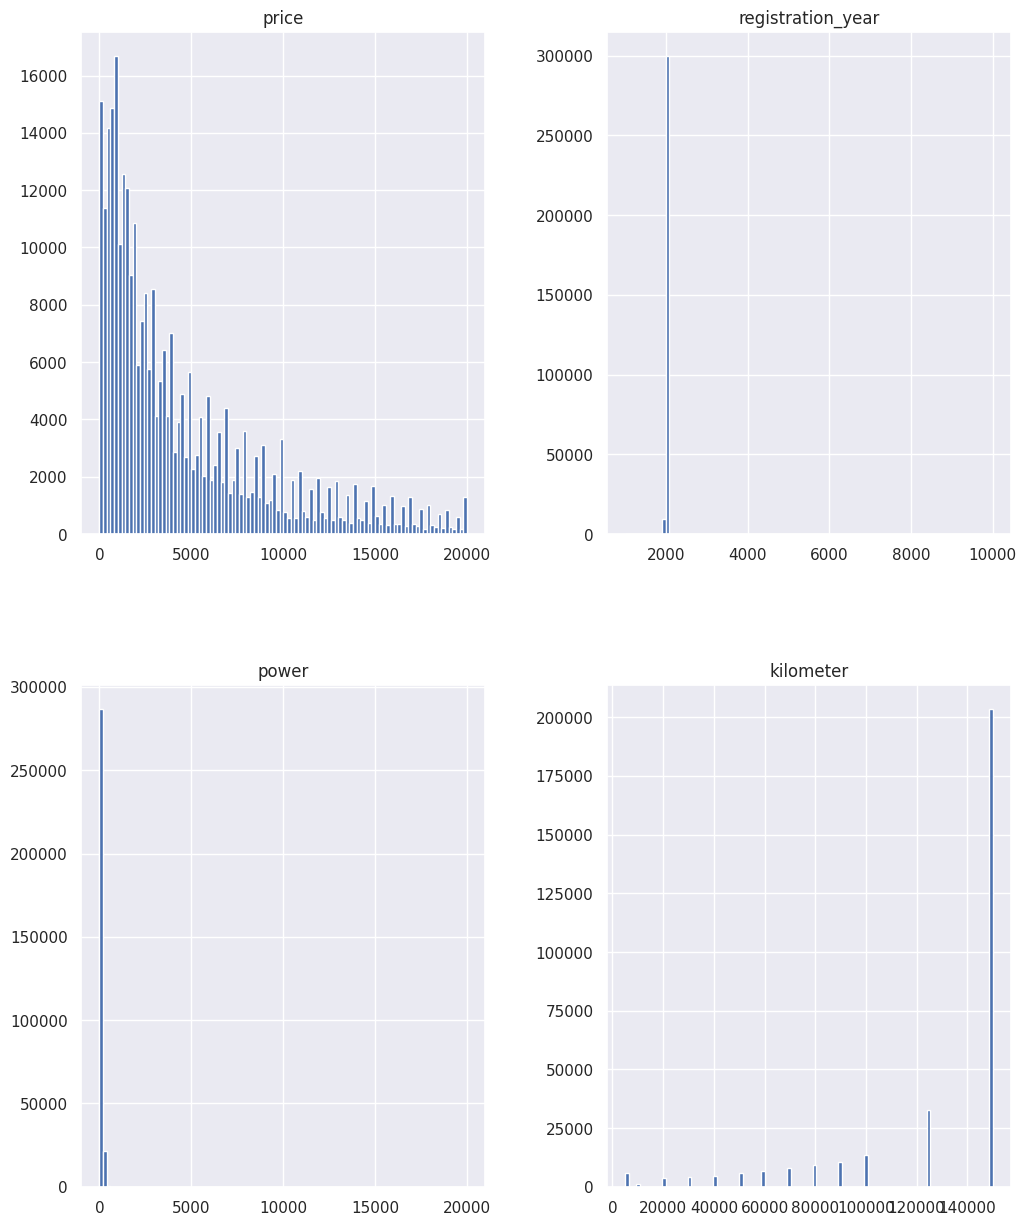

In [32]:
autos.hist(figsize=(12, 15), bins = 100)

plt.show()

По результатам анализа гистограмм можно сказать:
- с ценой есть проблема нулевой цены, которую неизвестно как решать, поскольку дополнительные данные взять неоткуда.
- в столбцах "год регистрации" и "мощность" явныевыбросы в высоких значениях, их отдельно внимательно рассмотрим на диаграммах "ящик с усами".
- в столбце "километры видим много машин с большим пробегом, но это нормально
- в месяце регистрации 0 месяц - это явно ошибка какая-то, в идеале его бы раскидать равномерно по всем месяцам, тогд аобщее распределение не испортится.
- С почтовыми кодами проблем на первый взгляд нет, но хотелось бы понимать, из скольки знаков они должны быть. Однако, я даже не знаю страну откуда взяты данные, так что этот столбец оставим как есть.


In [33]:
num_columns = autos.select_dtypes(include='number').columns
cat_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']

In [34]:
num_columns

Index(['price', 'registration_year', 'power', 'kilometer'], dtype='object')

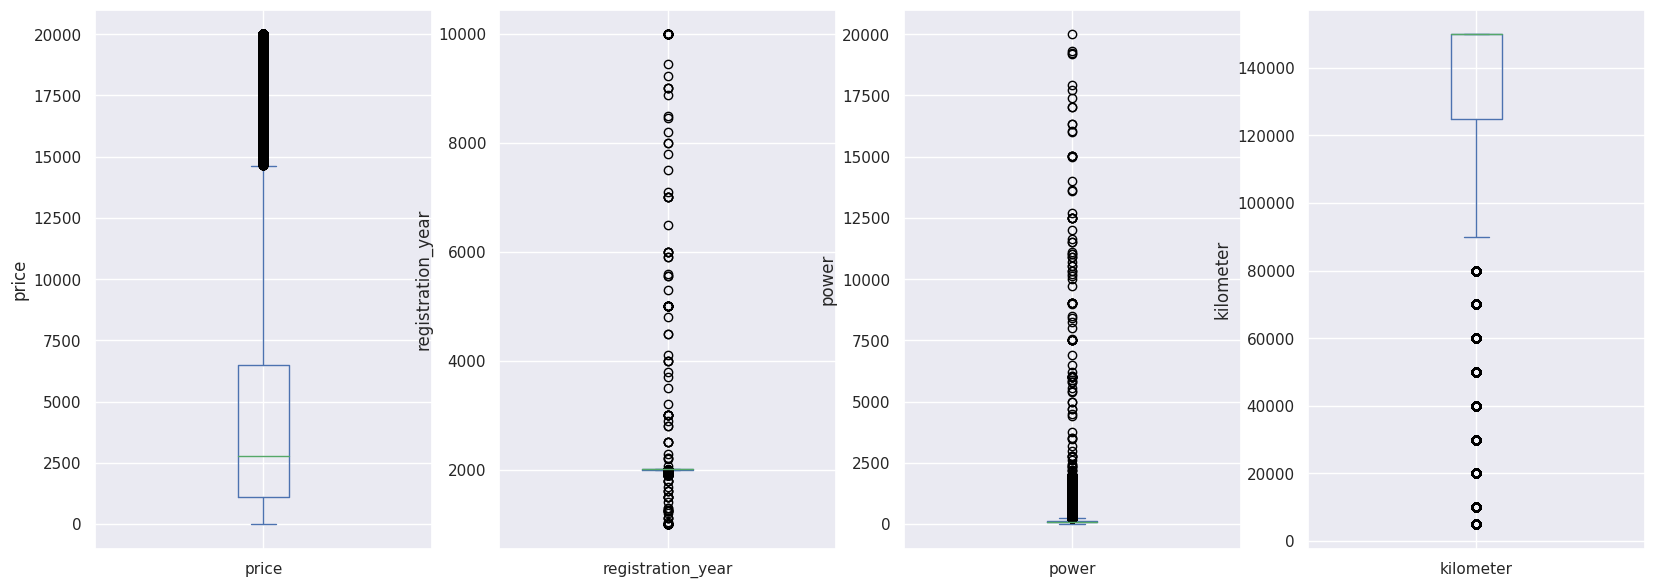

In [35]:
fig, axarr = plt.subplots(1, len(num_columns), figsize=(20, 7))

i=0
for column in num_columns:
    autos[column].plot.box(
        ylabel=column,
        ax=axarr[i],
        )

    i+=1

plt.show()

Выбросы по столбцам:
- В столбце `price` скорее всего не выбросы, а реальные данные, отражающие сегмент дорогих машин: не удаляем, но нижнюю часть нужно скорректировать: ноль машина стоить не может, как и вряд ли она будет дешевле 100 евро. С этим поработаем.
- В столбце `registration_year` много выбросов, здесь следует заменить все, что ниже 1920 и все, что выше 2016го (когда произошло скачивание данных анкет) на NAN
- В столбце `power` все, что больше 1000 - заменить также на NAN, поскольку на 2016 год максимальная мощность автомобиля составляла именно столько
- В оставшихся столбцах аномалий (выбросов) нет

In [36]:
def rewrite(row):
    if (row['registration_year']>2016 or row['registration_year']<1920):
        return np.NaN
    else:
        return row['registration_year']
    return row['registration_year']
autos['registration_year']=autos.apply(rewrite, axis=1)

In [37]:
# А теперь удалим эти неизвестные года.
autos = autos.loc[~autos['registration_year'].isna()]

In [38]:
def rewrite(row):
    if (row['power']==0):
        return np.NaN
    elif row['power']>10000:
        return row['power']/100
    elif row['power']>1000:
        return row['power']/10
    elif row['power']>0 and row['power']<100:
        return row['power']*10
    else:
        return row['power']
    return row['power']
autos['power']=autos.apply(rewrite, axis=1)

In [39]:
# А теперь удалим эти нулевые цены.
autos = autos.loc[~autos['power'].isna()]

In [40]:
def rewrite(row):
    if (row['price']==0):
        return np.NaN
    else:
        return row['price']
    return row['price']
autos['price']=autos.apply(rewrite, axis=1)

In [41]:
# А теперь удалим эти нулевые цены.
autos = autos.loc[~autos['price'].isna()]

In [42]:
autos.describe()

,price,registration_year,power,kilometer
count,257795.000000,257795.000000,257795.000000,257795.000000
mean,4938.840171,2002.864047,347.461543,127215.229155
std,4662.756090,6.698794,285.416427,37487.641871
min,1.000000,1923.000000,10.000000,5000.000000
25%,1350.000000,1999.000000,125.000000,125000.000000
50%,3290.000000,2003.000000,170.000000,150000.000000
75%,7000.000000,2007.000000,600.000000,150000.000000
max,20000.000000,2016.000000,1000.000000,150000.000000


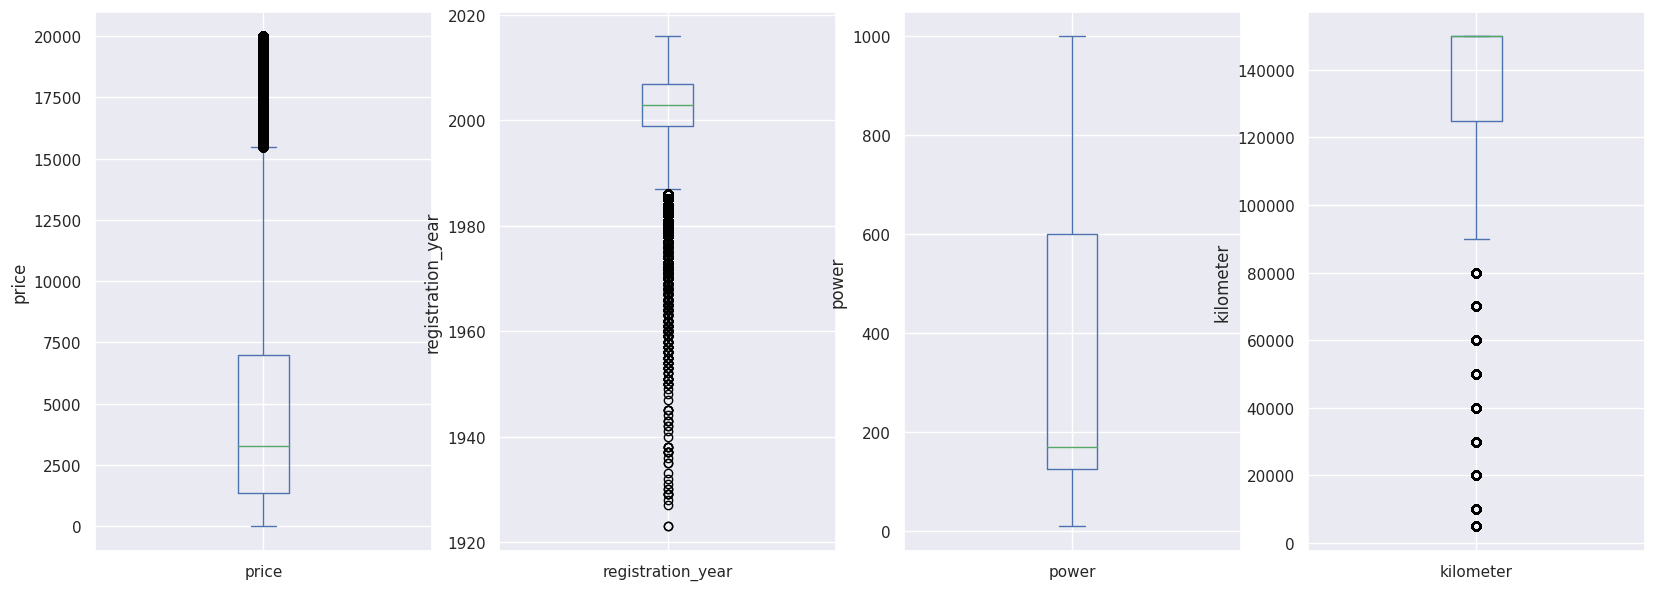

In [43]:
fig, axarr = plt.subplots(1, len(num_columns), figsize=(20, 7))

i=0
for column in num_columns:
    autos[column].plot.box(
        ylabel=column,
        ax=axarr[i],
        )

    i+=1

plt.show()

Выглядит, конечно, все еще странно, но уже лучше, чем было. Теперь можно считать, что в числовых столбцах остались только редко встречающиеся значения.

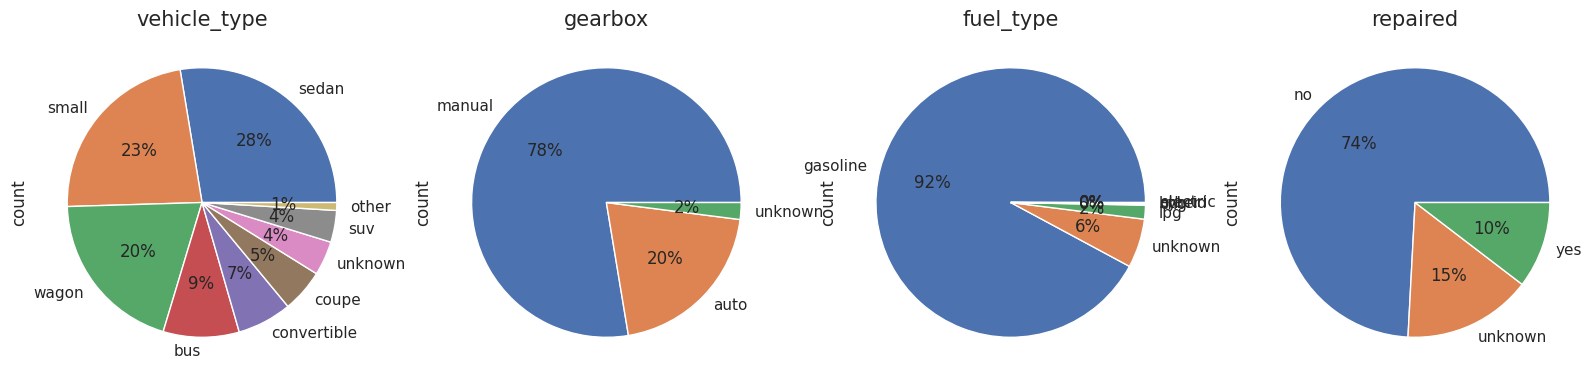

In [44]:
c_columns=['vehicle_type', 'gearbox', 'fuel_type', 'repaired']
fig, axarr = plt.subplots(1, 4)
i=0
for column in c_columns:
    autos[column].value_counts().plot.pie(
        ax=axarr[i],
        autopct = '%1.0f%%'
        )
    axarr[i].set_title(column, fontsize=15)
    i+=1
plt.show()

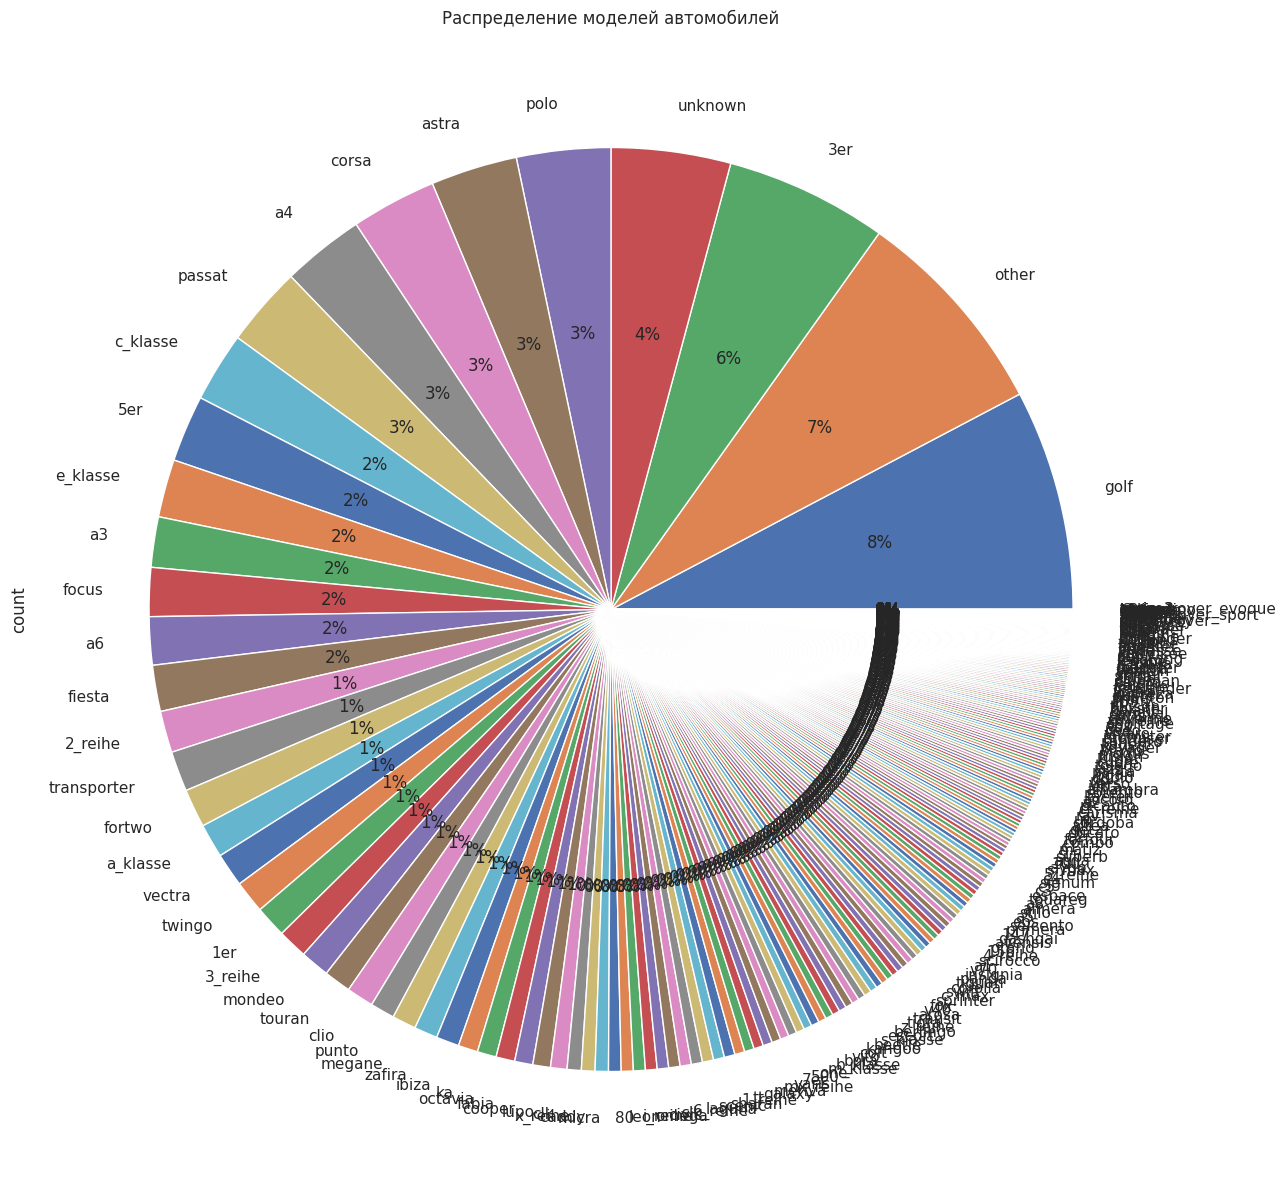

In [45]:
autos['model'].value_counts().plot.pie(autopct = '%1.0f%%', figsize=(20, 15))
plt.title(label="Распределение моделей автомобилей", loc ='center');

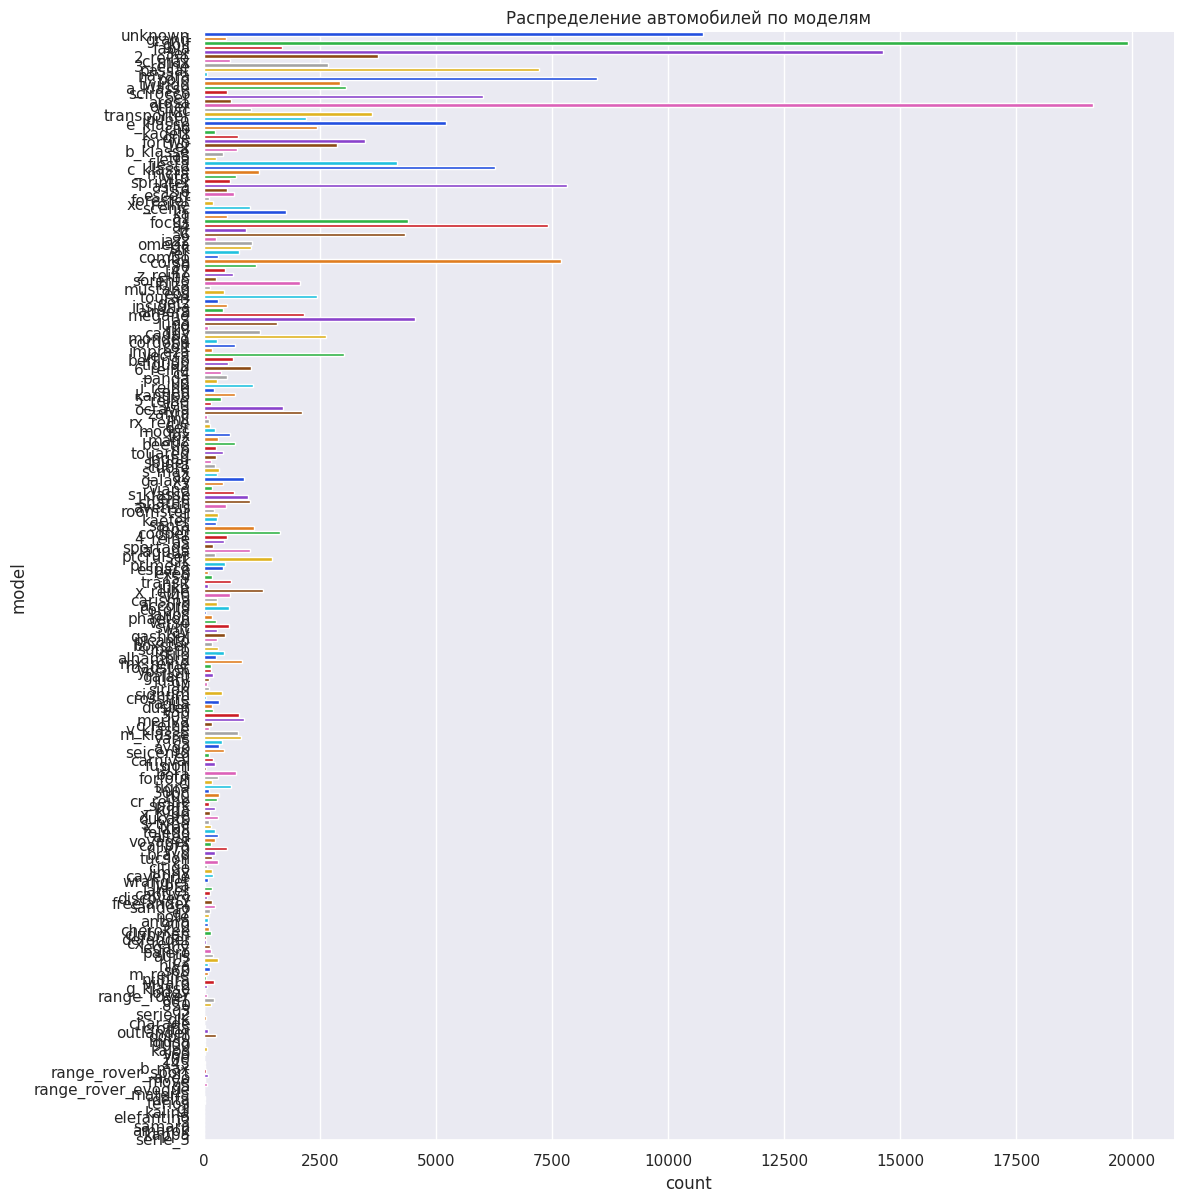

In [46]:
sns.catplot(data = autos, y= 'model', kind='count', palette="bright", height= 12 , aspect= 1.0 )
plt.title(label="Распределение автомобилей по моделям", loc ='center');

Модели машин вообще нет смысла смотреть, непоказательны. Можно все, что меньше 1% записать в other, но на практике было выяснено, что это ухудшает метрику как линейной модели, так и дерева решений (более 3000)
А в целом по категориальным столбцам ничего особенного сказать нельзя.

In [47]:
autos['fuel_type'] = autos.fuel_type.str.replace('petrol', 'gasoline')

Посмотрим парные корреляции по числовым столбцам:

''

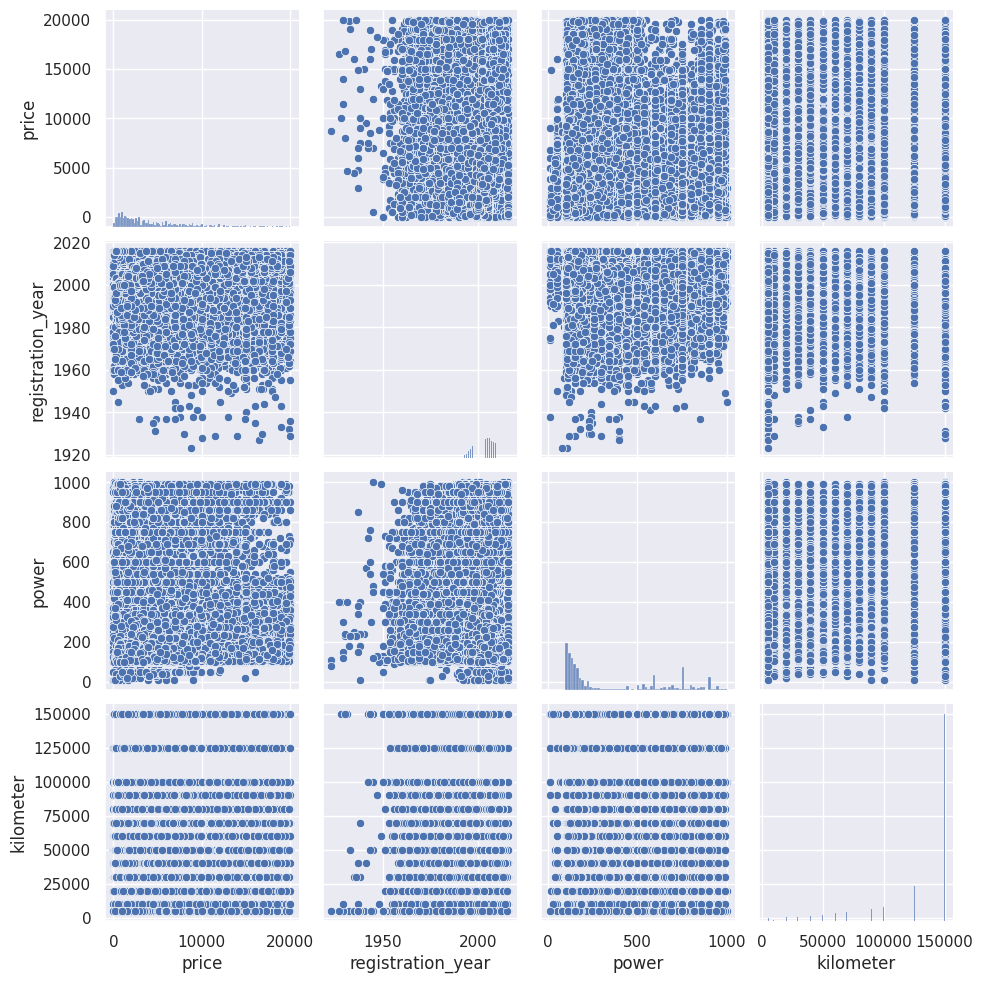

In [48]:
sns.pairplot(autos)
# plt.title(label="Матрица диаграмм рассеяния (парные графики)") # название уходит в поле графиков
;

Показательнее будет тепловая карта

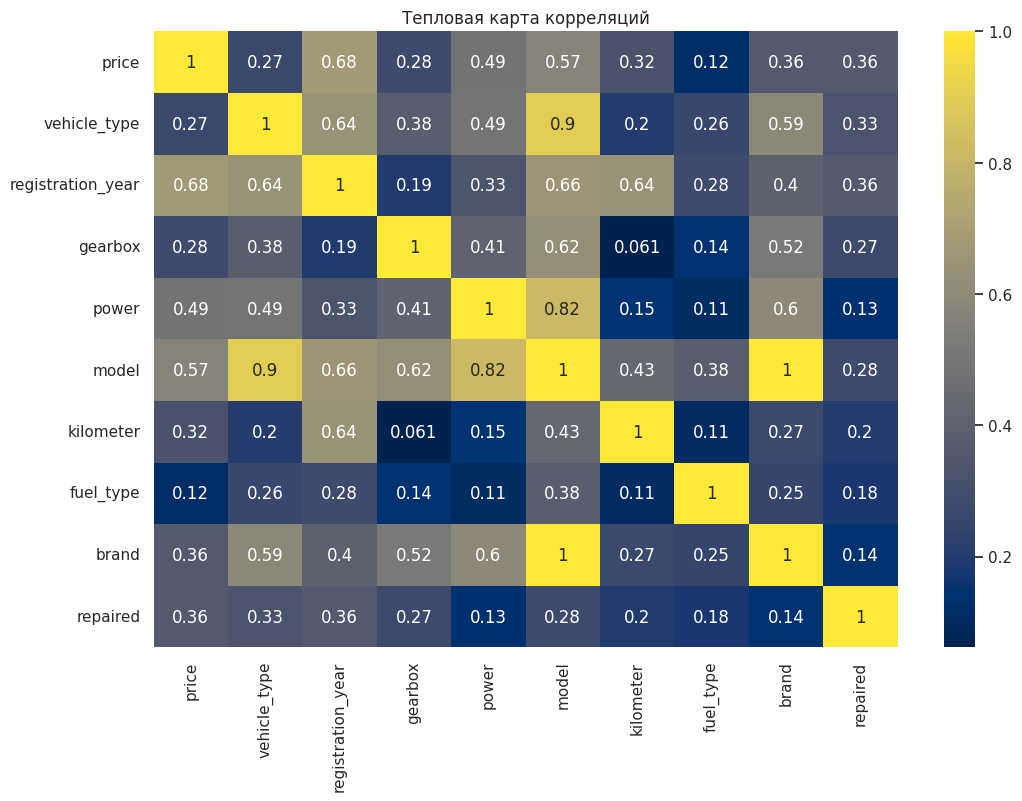

In [49]:
plt.figure(figsize = (12,8))
sns.heatmap(autos.phik_matrix(interval_cols=['price', 'power']), annot=True, cmap='cividis')
plt.title(label="Тепловая карта корреляций");

По тепловой карте видны корреляции, но они не очень высокие.
Цена автомобиля коррелирует с коэффициентом корреляции:
- 0,68 с годом регистрации
- 0,49 с мощностью
- 0,36 - с брендом и реомонтом

Мультиколлинеарность не наблюдается, признаки можно не удалять.
Передадим данные модели.

### Промежуточный вывод
В процессе подготовки данных:
- Удалены три столбца с датами:`DateCrawled` (дата скачивания анкеты из базы), `DateCreated` (дата создания анкеты), `LastSeen` (дата последней активности пользователя), поскольку эти даты не несут никакой информации, от которой может зависеть цена авто
- Удален столбец `NumberOfPictures` (количество фотографий автомобиля), поскольку в нем только нули
- Удален столбец `RegistrationMonth`, поскольку он не влияет на цену
- Удален столбец `PostalCode`, поскольку он не влияет на цену
- В столбце `RegistrationYear`(год регистрации автомобиля) все, что ниже 1905 и все, что выше 2016го (когда произошло скачивание аднных анкет), удалено
- Остальные столбцы:
  - `Power` - мощность, л.с.
  - `VehicleType` — тип автомобильного кузова
  - `Gearbox` — тип коробки передач
  - `Model` — модель автомобиля
  - `Kilometer` — пробег (км)
  - `RegistrationMonth` — месяц регистрации автомобиля
  - `FuelType` — тип топлива
  - `Brand` — марка автомобиля
  - `Repaired` — была машина в ремонте или нет
 обработаны аномалии, все пропуски, которые имелись, заменены на `unknown`

Мультиколлинеарности нет.
Данные переданы модели.

## Обучение моделей

In [50]:
autos.head(1)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300.0,coupe,2011.0,manual,190.0,unknown,125000,gasoline,audi,yes


In [51]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257795 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              257795 non-null  float64
 1   vehicle_type       257795 non-null  object 
 2   registration_year  257795 non-null  float64
 3   gearbox            257795 non-null  object 
 4   power              257795 non-null  float64
 5   model              257795 non-null  object 
 6   kilometer          257795 non-null  int64  
 7   fuel_type          257795 non-null  object 
 8   brand              257795 non-null  object 
 9   repaired           257795 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 21.6+ MB


Целевой столбец `price` числовой, target encoding делать не требуется\
Построим списки колонок для кодировщиков и скейлеров для линейной модели
- Целевой признак: `price`
- Категориальные признаки: `vehicle_type`, `gearbox`, `model`, `fuel_type`, `brand`, `repaired`
- Ранговые признаки: ранговых признаков нет, но, поскольку в категориальных слишком много категорий, лучше закодировать их кодировщиком Ord - так мы не размножим количество колонок и сократим время обучения.
Итак, финально:
- Категориальные признаки для Ohe: `gearbox`,`repaired`
- Категориальные признаки для Ord: `vehicle_type`,  `model`, `fuel_type`, `brand`
- Числовые признаки: `registration_year`, `power`, `kilometer`, `registration_month`, `postal_code`

In [52]:
ohe_columns = [
    'vehicle_type',
    'gearbox',
    'model',
    'fuel_type',
    'brand',
    'repaired',
]

num_columns = [
    'registration_year',
    'power',
    'kilometer',
]

In [53]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X=autos.drop(['price'], axis=1)
y=autos['price']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    #stratify =  autos['price'] - почему-то ругается, что в самом маленьком классе только один участник получается в таком случае
)

X_train.shape, X_test.shape

((193346, 9), (64449, 9))

In [54]:
autos.isna().sum()

,0
price,0
vehicle_type,0
registration_year,0
gearbox,0
power,0
model,0
kilometer,0
fuel_type,0
brand,0
repaired,0


In [55]:
ord_dict = [
    autos['vehicle_type'].unique(),
    autos['model'].unique(),
    autos['fuel_type'].unique(),
    autos['brand'].unique(),
    autos['gearbox'].unique(),
    autos['repaired'].unique(),
]

In [56]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer (закомментируем, оставив для необходимости) + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False
                          ))
    ]
    )
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=ord_dict,
               handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [57]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

Создаем результирующую таблицу:

In [58]:
result_table = pd.DataFrame(columns=['model', 'RMSE', 'train_time', 'predict_time'])

Пишем метрику:

In [59]:
def RMSE(target, predict):
    return abs((mean_squared_error(target, predict))**0.5)

#С помощию функции make_scorer создаю метрику RMSE
rmse = make_scorer(RMSE, greater_is_better=False)

### Модель LinearRegression

In [60]:
## Кодируем выборки
X_train_lr = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)

In [61]:
%%time

#инициализируем и обучаем модель
lr_model = LinearRegression()

#настраиваем поиск по сетке
# параметры
lr_params = {}

lr_gs_model = GridSearchCV(lr_model,
                             lr_params,
                             cv=5,
                             scoring = rmse,
                             n_jobs=-1)

lr_gs_model.fit(X_train_lr, y_train)
lr_gs_model.best_params_
print('Лучшая модель и её параметры:\n\n', lr_gs_model.best_params_)
-lr_gs_model.best_score_

Лучшая модель и её параметры:

 {}
CPU times: user 13.5 s, sys: 691 ms, total: 14.2 s
Wall time: 42.5 s


2859.249875308653

In [62]:
%%time
start = time.time()
lr_model = lr_gs_model.best_estimator_
lr_model.fit(X_train_lr, y_train)
end = time.time()
train_time = (end-start)/60
print(f'Время обучения модели LinReg: {train_time} мин')

start = time.time()
lr_model.predict(X_train_lr)
end = time.time()
predict_time = (end-start)/60
print(f'Время предсказания модели LinReg: {predict_time} мин')

Время обучения модели LinReg: 0.1738336682319641 мин
Время предсказания модели LinReg: 0.0032537261644999186 мин
CPU times: user 14 s, sys: 333 ms, total: 14.4 s
Wall time: 10.6 s


In [63]:
result_table_1 = pd.DataFrame(
            {
                'model': 'LinearRegression', 'RMSE': round(-lr_gs_model.best_score_, 2),
                'train_time': round(train_time, 4), 'predict_time': round(predict_time, 4)
                }, index=[0])
result_table = pd.concat([result_table, result_table_1], ignore_index = True)
result_table

,model,RMSE,train_time,predict_time
0,LinearRegression,2859.25,0.1738,0.0033


### Модель DecisionTree

In [64]:
ord_columns = [
    'vehicle_type',
    'model',
    'fuel_type',
    'brand',
    'gearbox',
    'repaired',
]

In [65]:
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [66]:
## Кодируем выборку

X_train_dt = pd.DataFrame(data_preprocessor.fit_transform(X_train))

In [67]:

%%time
#инициализируем и обучаем модель
dt_model = DecisionTreeRegressor(random_state=RANDOM_STATE)
#настраиваем поиск по сетке
# параметры
dt_params = {
    'max_features': range(15, 20, 5),
    'max_depth': range(11, 15, 2),
    'min_samples_leaf': range(2,5),
    'min_samples_split': range(4,8,2) }

dt_gs_model = GridSearchCV(dt_model,
                           dt_params,
                           scoring=rmse,
                           cv=5,
                           n_jobs=-1)

dt_gs_model.fit(X_train_dt, y_train)
dt_gs_model.best_params_
print('Лучшая модель и её параметры:\n\n', dt_gs_model.best_params_)
dt_gs_model.best_score_columns=data_preprocessor.get_feature_names_out()
-dt_gs_model.best_score_

Лучшая модель и её параметры:

 {'max_depth': 13, 'max_features': 15, 'min_samples_leaf': 4, 'min_samples_split': 4}
CPU times: user 1.17 s, sys: 143 ms, total: 1.32 s
Wall time: 25 s


1971.4616886808362

In [68]:
%%time
start = time.time()
dt_model = dt_gs_model.best_estimator_
dt_model.fit(X_train_dt, y_train)
end = time.time()
train_time = (end-start)/60
print(f'Время обучения модели DecisionTree: {train_time} мин')

start = time.time()
dt_model.predict(X_train_dt)
end = time.time()
predict_time = (end-start)/60
print(f'Время предсказания модели DecisionTree: {predict_time} мин')

Время обучения модели DecisionTree: 0.014821974436442058 мин
Время предсказания модели DecisionTree: 0.0006207426389058431 мин
CPU times: user 897 ms, sys: 0 ns, total: 897 ms
Wall time: 928 ms


In [69]:
result_table_2 = pd.DataFrame(
            {
                'model': 'DecisionTreeRegressor', 'RMSE': round(-dt_gs_model.best_score_, 2),
                'train_time': round(train_time, 4), 'predict_time': round(predict_time, 4)
                }, index=[1])
result_table = pd.concat([result_table, result_table_2], ignore_index = True)
result_table

,model,RMSE,train_time,predict_time
0,LinearRegression,2859.25,0.1738,0.0033
1,DecisionTreeRegressor,1971.46,0.0148,0.0006


### Модель RandomForest

In [70]:
## Кодируем выборку

X_train_rf = pd.DataFrame(data_preprocessor.fit_transform(X_train))

In [71]:

%%time
#инициализируем и обучаем модель
rf_model = RandomForestRegressor(random_state=RANDOM_STATE)
#настраиваем поиск по сетке
# параметры
rf_params = {
    'max_features': [15,20],
    'max_depth': [13, 15],
    'min_samples_leaf': [2,4],
    'min_samples_split': [3,5] }

rf_gs_model = GridSearchCV(rf_model,
                           rf_params,
                           scoring=rmse,
                           cv=5,
                           n_jobs=-1)

rf_gs_model.fit(X_train_rf, y_train)
rf_gs_model.best_params_
print('Лучшая модель и её параметры:\n\n', rf_gs_model.best_params_)
rf_gs_model.best_score_columns=data_preprocessor.get_feature_names_out()
-rf_gs_model.best_score_

Лучшая модель и её параметры:

 {'max_depth': 15, 'max_features': 15, 'min_samples_leaf': 2, 'min_samples_split': 3}
CPU times: user 1min 17s, sys: 5.25 s, total: 1min 23s
Wall time: 43min 26s


1745.3806729089235

In [72]:
%%time
start = time.time()
rf_model = rf_gs_model.best_estimator_
rf_model.fit(X_train_rf, y_train)
end = time.time()
train_time = (end-start)/60
print(f'Время обучения модели RandomForestRegressor: {train_time} мин')

start = time.time()
rf_model.predict(X_train_rf)
end = time.time()
predict_time = (end-start)/60
print(f'Время предсказания модели RandomForestRegressor: {predict_time} мин')

Время обучения модели RandomForestRegressor: 0.8298328757286072 мин
Время предсказания модели RandomForestRegressor: 0.06676173210144043 мин
CPU times: user 53.3 s, sys: 39.7 ms, total: 53.3 s
Wall time: 53.8 s


In [73]:
result_table_3 = pd.DataFrame(
            {
                'model': 'RandomForestRegressor', 'RMSE': round(-rf_gs_model.best_score_, 2),
                'train_time': round(train_time, 4), 'predict_time': round(predict_time, 4)
                }, index=[2])
result_table = pd.concat([result_table, result_table_3], ignore_index = True)
result_table

,model,RMSE,train_time,predict_time
0,LinearRegression,2859.25,0.1738,0.0033
1,DecisionTreeRegressor,1971.46,0.0148,0.0006
2,RandomForestRegressor,1745.38,0.8298,0.0668


### Модель LGBMRegressor

In [74]:
#Переводим в категориальные
X_train_lgbm = X_train.copy()
#X_valid_lgbm = X_valid.copy()

cat_columns = ['vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'fuel_type', 'brand', 'repaired']

for c in cat_columns:
    X_train_lgbm[c] = X_train_lgbm[c].astype('category')
    #X_valid_lgbm[c] = X_valid_lgbm[c].astype('category')

In [75]:
%%time
#инициализируем модель
lgb_model = LGBMRegressor(random_state=RANDOM_STATE)
#настраиваем поиск по сетке
# параметры
lgbm_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'learning_rate': [0.1, 0.2]
}

lgbm_gs_model = GridSearchCV(lgb_model,
                           lgbm_params,
                           scoring=rmse,
                           cv=5,
                           n_jobs=-1,
                             verbose=False)

lgbm_gs_model.fit(X_train_lgbm, y_train)
lgbm_gs_model.best_params_
print('Лучшая модель и её параметры:\n\n', lgbm_gs_model.best_params_)
lgbm_gs_model.best_score_columns=data_preprocessor.get_feature_names_out()
-lgbm_gs_model.best_score_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 193346, number of used features: 9
[LightGBM] [Info] Start training from score 4940.492113
Лучшая модель и её параметры:

 {'learning_rate': 0.2, 'max_depth': 20, 'n_estimators': 200}
CPU times: user 7.24 s, sys: 682 ms, total: 7.92 s
Wall time: 3min 43s


1657.137924342512

In [76]:
%%time
start = time.time()
lgb_model=lgbm_gs_model.best_estimator_
lgb_model.fit(X_train_lgbm, y_train)
end = time.time()
train_time = (end-start)/60
print(f'Время обучения модели LGBMRegressor: {train_time} мин')

start = time.time()
lgb_model.predict(X_train_lgbm)
end = time.time()
predict_time = (end-start)/60
print(f'Время предсказания модели LGBMRegressor: {predict_time} мин')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 193346, number of used features: 9
[LightGBM] [Info] Start training from score 4940.492113
Время обучения модели LGBMRegressor: 0.0521678884824117 мин
Время предсказания модели LGBMRegressor: 0.04773264328638713 мин
CPU times: user 5.96 s, sys: 27.7 ms, total: 5.99 s
Wall time: 6 s


In [77]:
result_table_4 = pd.DataFrame(
            {
                'model': 'LGBMRegressor', 'RMSE': round(-lgbm_gs_model.best_score_, 2),
                'train_time': round(train_time, 4), 'predict_time': round(predict_time, 4)
                }, index=[3])
result_table = pd.concat([result_table, result_table_4], ignore_index = True)
result_table


,model,RMSE,train_time,predict_time
0,LinearRegression,2859.25,0.1738,0.0033
1,DecisionTreeRegressor,1971.46,0.0148,0.0006
2,RandomForestRegressor,1745.38,0.8298,0.0668
3,LGBMRegressor,1657.14,0.0522,0.0477


### Модель CatBoost

In [78]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193346 entries, 111726 to 156598
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   vehicle_type       193346 non-null  object 
 1   registration_year  193346 non-null  float64
 2   gearbox            193346 non-null  object 
 3   power              193346 non-null  float64
 4   model              193346 non-null  object 
 5   kilometer          193346 non-null  int64  
 6   fuel_type          193346 non-null  object 
 7   brand              193346 non-null  object 
 8   repaired           193346 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 14.8+ MB


In [79]:
X_train_cb = X_train.copy()
#X_valid_cb = X_valid.copy()

X_train_cb.fillna('unknown', inplace=True)
#X_valid_cb.fillna('unknown', inplace=True)



In [80]:
%%time
#инициализируем модель
ctb_model = CatBoostRegressor(random_state=RANDOM_STATE,
                              cat_features=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'],
                              verbose =100)

# подбор параметров
catb_params = {
    "n_estimators": [400, 600],
    'learning_rate': [0.1, 0.2],
              }
#настраиваем поиск по сетке
catb_gs_model = GridSearchCV(ctb_model,
                             catb_params,
                             cv=5,
                             scoring =rmse,
                             n_jobs=-1)


catb_gs_model.fit(X_train_cb, y_train)
catb_gs_model.best_params_
print('Лучшая модель и её параметры:\n\n', catb_gs_model.best_params_)
catb_gs_model.best_score_columns=data_preprocessor.get_feature_names_out()
-catb_gs_model.best_score_

0:	learn: 4081.8073086	total: 280ms	remaining: 2m 47s
100:	learn: 1741.6804724	total: 22.4s	remaining: 1m 50s
200:	learn: 1674.1458808	total: 47s	remaining: 1m 33s
300:	learn: 1641.1998774	total: 1m 8s	remaining: 1m 7s
400:	learn: 1619.1940940	total: 1m 33s	remaining: 46.2s
500:	learn: 1598.9052094	total: 1m 55s	remaining: 22.8s
599:	learn: 1582.2125761	total: 2m 19s	remaining: 0us
Лучшая модель и её параметры:

 {'learning_rate': 0.2, 'n_estimators': 600}
CPU times: user 4min 8s, sys: 6.17 s, total: 4min 14s
Wall time: 33min 49s


1663.5708121349776

In [81]:
%%time
start = time.time()
ctb_model=catb_gs_model.best_estimator_
ctb_model.fit(X_train_cb, y_train)
end = time.time()
train_time = (end-start)/60
print(f'Время обучения модели CatBoostRegressor: {train_time} мин')

start = time.time()
ctb_model.predict(X_train_cb)
end = time.time()
predict_time = (end-start)/60
print(f'Время предсказания модели CatBoostRegressor: {predict_time} мин')

0:	learn: 4081.8073086	total: 209ms	remaining: 2m 4s
100:	learn: 1741.6804724	total: 22.8s	remaining: 1m 52s
200:	learn: 1674.1458808	total: 46.6s	remaining: 1m 32s
300:	learn: 1641.1998774	total: 1m 8s	remaining: 1m 8s
400:	learn: 1619.1940940	total: 1m 35s	remaining: 47.2s
500:	learn: 1598.9052094	total: 1m 59s	remaining: 23.6s
599:	learn: 1582.2125761	total: 2m 20s	remaining: 0us
Время обучения модели CatBoostRegressor: 2.3563719709714253 мин
Время предсказания модели CatBoostRegressor: 0.022477591037750246 мин
CPU times: user 3min 47s, sys: 2.29 s, total: 3min 49s
Wall time: 2min 22s


In [82]:
result_table_5 = pd.DataFrame(
            {
                'model': 'CatBoostRegressor', 'RMSE': round(-catb_gs_model.best_score_, 2),
                'train_time': round(train_time, 4), 'predict_time': round(predict_time, 4)
                }, index=[4])
result_table = pd.concat([result_table, result_table_5], ignore_index = True)
result_table

,model,RMSE,train_time,predict_time
0,LinearRegression,2859.25,0.1738,0.0033
1,DecisionTreeRegressor,1971.46,0.0148,0.0006
2,RandomForestRegressor,1745.38,0.8298,0.0668
3,LGBMRegressor,1657.14,0.0522,0.0477
4,CatBoostRegressor,1663.57,2.3564,0.0225


## Анализ моделей

### Анализ таблицы и проверка выбранной модели на тестовой выборке

In [83]:
result_table

,model,RMSE,train_time,predict_time
0,LinearRegression,2859.25,0.1738,0.0033
1,DecisionTreeRegressor,1971.46,0.0148,0.0006
2,RandomForestRegressor,1745.38,0.8298,0.0668
3,LGBMRegressor,1657.14,0.0522,0.0477
4,CatBoostRegressor,1663.57,2.3564,0.0225


Лучшую метрику выдают модели LightGBM и CatBoost, но CatBoost долго учится\
LightGBM учится гораздо быстрее, а метрика у нее даже чуть лучше (хотя, полагаю, это в пределах ошибки)\

Предлагаю к выбору модель: LGBMRegressor

**Проверяем модель LGBMRegressor на тестовой выборке:**

In [95]:
#Переводим признаки в категориальные
X_test_lgbm = X_test.copy()

for c in cat_columns:
    X_test_lgbm[c] = X_test_lgbm[c].astype('category')

start_time = time.time()
y_pred = lgb_model.predict(X_test_lgbm)
end_time = time.time()
predict_time = end_time - start_time

print(f'Время предсказания модели LGBMRegressor: {predict_time} сек')

rmse =  mean_squared_error (y_test, y_pred, squared=False)
print(f'Метрика RMSE LGBMRegressor = {rmse:.4f}')

Время предсказания модели LGBMRegressor: 0.9811742305755615 сек
Метрика RMSE LGBMRegressor = 1638.6927


Метрика проходит по условиям задачи. Модель принята к рекомендации заказчику.

### Проверка модели на адекватность

In [98]:
# DummyRegressor модель
dummy_model = DummyRegressor()
dummy_model.fit(X_train, y_train)
dummy_prediction = dummy_model.predict(X_test)
rmse_dummy = (mean_squared_error(y_test, dummy_prediction))**0.5

print(f'RMSE DummyRegressor = {rmse_dummy:.4f}')

RMSE DummyRegressor = 4666.7201


In [97]:
print(f'Метрика RMSE LGBMRegressor = {rmse:.4f}')

Метрика RMSE LGBMRegressor = 1638.6927


Модель адекватна: ее метрика RMSE значительно ниже, чем у рандомной модели.

## Общий вывод

Были исследованы данные сервиса по продаже автомобилей с пробегом «Не бит, не крашен».\
Данные находятся в одном файле.

В процессе подготовки данных:
- Удалены три столбца с датами:`DateCrawled` (дата скачивания анкеты из базы), `DateCreated` (дата создания анкеты), `LastSeen` (дата последней активности пользователя), поскольку эти даты не несут никакой информации, от которой может зависеть цена авто
- Удален столбец `NumberOfPictures` (количество фотографий автомобиля), поскольку в нем только нули
- Удален столбец `RegistrationMonth`, поскольку он не влияет на цену
- Удален столбец `PostalCode`, поскольку он не влияет на цену
- В столбце `RegistrationYear`(год регистрации автомобиля) все, что ниже 1905 и все, что выше 2016го (когда произошло скачивание аднных анкет), удалено
- Остальные столбцы:
  - `Power` - мощность, л.с.
  - `VehicleType` — тип автомобильного кузова
  - `Gearbox` — тип коробки передач
  - `Model` — модель автомобиля
  - `Kilometer` — пробег (км)
  - `RegistrationMonth` — месяц регистрации автомобиля
  - `FuelType` — тип топлива
  - `Brand` — марка автомобиля
  - `Repaired` — была машина в ремонте или нет
 обработаны аномалии, все пропуски, которые имелись, заменены на `unknown`

Мультиколлинеарности нет.
Данные переданы модели.

Данные переданы моделям.
Были проверены модели:
- Линейная регрессия
- Дерево решений
- Случайный лес
- LGBMRegressor
- CatBoost
Для всех моделей произведен подбор параметров и валидация методом кросс-валидации.

По итогам выбрана лучшая модель - LGBMRegressor
Модель проверена на тестовой выборке, проверена на адекватность и по итогам предлагается для клиента модель LGBMRegressor с подобранными параметрами:
{'learning_rate': 0.2, 'max_depth': 20, 'n_estimators': 200}
выдающая на тестовой выборке метрику RMSE = 1638.6927
